In [2]:
# Imports
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
import cv2
from cv2 import imread, resize
from scipy.stats import spearmanr
from keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, GlobalAveragePooling2D, Input, TimeDistributed
from keras.models import Model
from keras.utils import Sequence
import keras.backend as K
from keras.optimizers import Adam, SGD
from timeit import default_timer as timer
import keras
import tensorflow as tf
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
import pickle
import json
from tqdm import tqdm_notebook as tqdm
import seaborn as sns

sys.path.append('../src/')
sys.path.append('../imgaug')
from generator import VideoSeqGenerator, preprocess_i3d_rgb
from vid_utils import load_video_opencv, plot_frames
from imgaug import augmenters as iaa
from imgaug import parameters as iap

import i3d_config as cfg
from keras_models import build_i3d_custom, build_model_multigpu

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# os.environ['CUDA_VISIBLE_DEVICES'] = '3'
print(os.environ['CUDA_VISIBLE_DEVICES'])


KeyError: 'CUDA_VISIBLE_DEVICES'

# Get data

In [3]:
TRAIN_ON = 'rgb'

if os.uname()[1] == 'visiongpu30':
    data_path = '../../../moments_raw/sources_numpy_256/' if TRAIN_ON=='rgb' else '../../../moments_flow/sources_flow_down1_tvl1_skip1/'
    labels_path = '../memento10k_labels/'
    names_with_slash = False
    load_func = 'npy_'+TRAIN_ON
else:
    data_path = '../../moments/10k_clean'
    labels_path = '../../moments/split'
    names_with_slash = True
    load_func = 'vids_opencv'

with open(os.path.join(labels_path, 'train_test_split_moments.pkl'), 'rb') as f:
    tt_s = pickle.load(f)
    
train_names=[]
val_names=[]
test_names=[]

# Fetch scores from ground truth json file with a defined T
T = 180
mem_scores_file = 'normalized_mem_scores_ma_T=%d.json' % T
alpha_file = 'alphas_ma_T=%d.json' % T

with open(os.path.join(labels_path, mem_scores_file)) as f:
    name_to_mem = json.load(f)
    
with open(os.path.join(labels_path, alpha_file)) as f:
    name_to_alpha = json.load(f)
    
# Getting dict in same format as vid names




name_to_mem_alpha={}

if names_with_slash:
    for n in tt_s[0]:
        cl = n.split('_')[0]
        cl = cl.replace('-','+')
        newn = cl+'/'+'_'.join(n.split('_')[1:])
        train_names.append(newn)

    for n in tt_s[1]:
        cl = n.split('_')[0]
        cl = cl.replace('-','+')
        newn = cl+'/'+'_'.join(n.split('_')[1:])
        val_names.append(newn)
        
    for k,v in name_to_mem.items():
        name_to_mem_alpha[k] = np.array([v, name_to_alpha[k]])
    
else:
    train_names = sorted([ n[:-4]+'.npy' for n in tt_s[0] ])
    val_names = sorted([ n[:-4]+'.npy' for n in tt_s[1] ])
    for k,v in name_to_mem.items():
        newk = k.replace('/','_').replace('+','-')[:-4]+'.npy' 
        name_to_mem_alpha[newk] = np.array([v, name_to_alpha[k]])
    
all_names_set = set(list(name_to_mem_alpha.keys()))
test_names = list(all_names_set - set(train_names) - set(val_names))
    


print(train_names[:5])
print(list(name_to_mem_alpha.keys())[:5])


# Check if all names are in dict
to_remove=[]
for tn in train_names:
    if not os.path.isfile(os.path.join(data_path, tn)):
        to_remove.append(tn)
    if tn not in name_to_mem_alpha.keys():
        print('Train vid not in dict:',tn)
        
if to_remove:
    for r in to_remove:
        train_names.remove(to_remove)
        
to_remove=[]
for tn in val_names:
    if not os.path.isfile(os.path.join(data_path, tn)):
        to_remove.append(tn)
    if tn not in name_to_mem_alpha.keys():
        print('Val vid not in dict:',tn)
    
if to_remove:
    for r in to_remove:
        val_names.remove(to_remove)

to_remove=[]
for tn in test_names:
    if not os.path.isfile(os.path.join(data_path, tn)):
        to_remove.append(tn)
    if tn not in name_to_mem_alpha.keys():
        print('Test vid not in dict:',tn)

if to_remove:
    for r in to_remove:
        test_names.remove(r)

print('Loaded %d train videos, %d val videos, %d test videos\n' % (len(train_names), len(val_names), len(test_names)))


['adult-female-singing_peeks-www_k_to_keek_2Qwueab_25.npy', 'adult-female-singing_peeks-www_k_to_keek_2Xyqeab_3.npy', 'adult-female-singing_peeks-www_k_to_keek_2g4teab_28.npy', 'adult-female-singing_peeks-www_k_to_keek_EO30eab_19.npy', 'adult-female-singing_peeks-www_k_to_keek_J2Rveab_1.npy']
['rolling_flickr-0-7-0-1-1-7-8-1-4007011781_26.npy', 'singing_flickr-7-0-5-6-8-9-6-7-3770568967_46.npy', 'flying_flickr-0-4-0-4-6-6-0-7-5504046607_55.npy', 'working_flickr-8-5-8-2-1-3-0-6-17285821306_7.npy', 'skating_flickr-1-2-9-4-2-9-7-2-3612942972_7.npy']
Loaded 7027 train videos, 1507 val videos, 1505 test videos



# Generator

In [4]:
# Instantiating generator
bs = 8

gen_train = VideoSeqGenerator(files=train_names,
                            batch_size=bs, 
                            has_label_col=False, 
                            dataset_path=data_path,
                            label_csv= None, #'../../moments/split/moments_mini_categories.txt',
                            augment=None,
                            load_func=load_func,
                            load_labels_func='mem_alpha',
                            preprocess_func='fast_'+TRAIN_ON,
                            remove_excess_files=False,
                            shuffle=False,
                            is_train=False,
                            it_per_epoch=None,
                            return_labels = True,
                            verbose=True,
                            str2label_dict = name_to_mem_alpha)

gen_val = VideoSeqGenerator(files=val_names,
                            batch_size=bs, 
                            has_label_col=False, 
                            dataset_path=data_path,
                            label_csv=None,
                            augment=None,
                            load_func=load_func,
                            load_labels_func='mem_alpha',
                            preprocess_func='fast_'+TRAIN_ON,
                            remove_excess_files=False,
                            shuffle=False,
                            is_train=False,
                            it_per_epoch=None,
                            return_labels = True,
                            verbose=True,
                            str2label_dict = name_to_mem_alpha)

gen_test = VideoSeqGenerator(files=test_names,
                            batch_size=bs, 
                            has_label_col=False, 
                            dataset_path=data_path,
                            label_csv=None,
                            augment=None,
                            load_func=load_func,
                            load_labels_func='mem_alpha',
                            preprocess_func='fast_'+TRAIN_ON,
                            remove_excess_files=False,
                            shuffle=False,
                            is_train=False,
                            it_per_epoch=None,
                            return_labels = True,
                            verbose=True,
                            str2label_dict = name_to_mem_alpha)

Caution: batch_size (8) is not multiple of given dataset length (7027). This can cause issues with multigpu training.
Calling VideoSeqGenerator. Batch size:  8 . Number of files received: 7027 . Augmentation:  None
Caution: batch_size (8) is not multiple of given dataset length (1507). This can cause issues with multigpu training.
Calling VideoSeqGenerator. Batch size:  8 . Number of files received: 1507 . Augmentation:  None
Caution: batch_size (8) is not multiple of given dataset length (1505). This can cause issues with multigpu training.
Calling VideoSeqGenerator. Batch size:  8 . Number of files received: 1505 . Augmentation:  None


# Test generator


Total time on this batch: 1.7870794711634517  - it: 0 - idx: 0
Time loading: 1.0738174356520176
Time preprocessing: 0.7132380492985249
Time augmenting: 2.398621290922165e-05


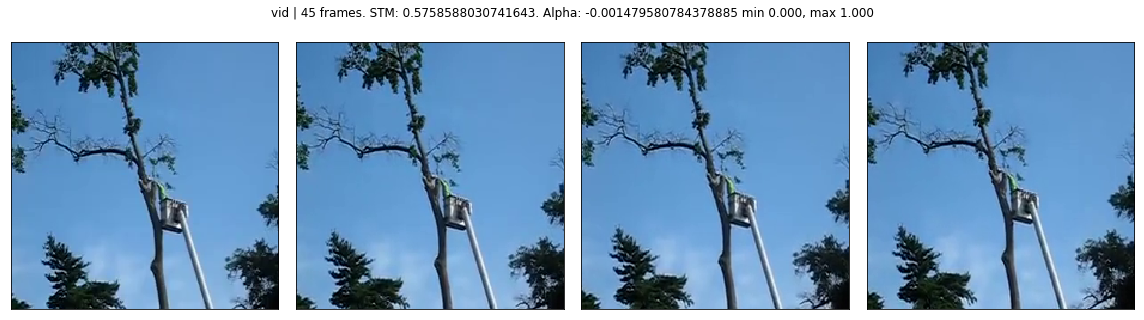

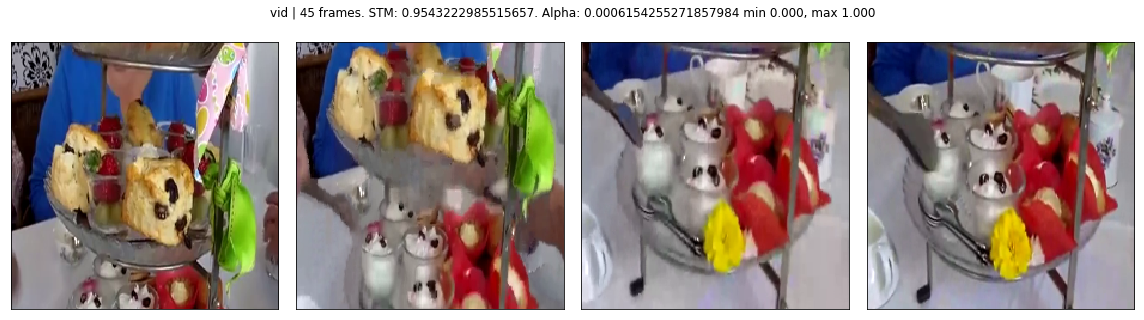

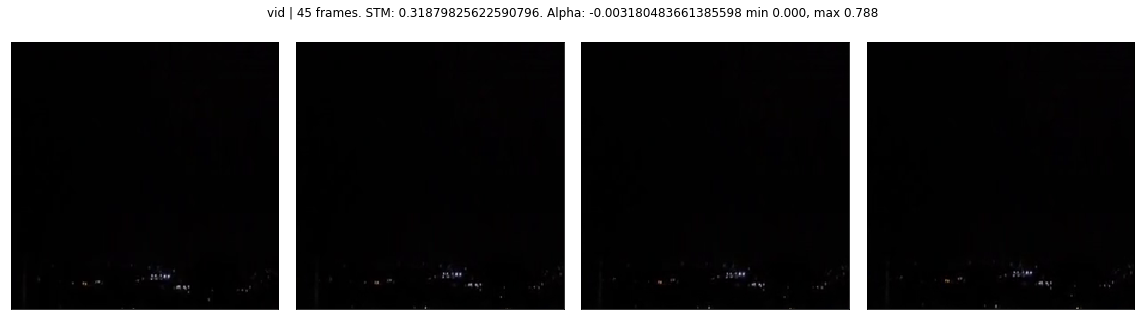

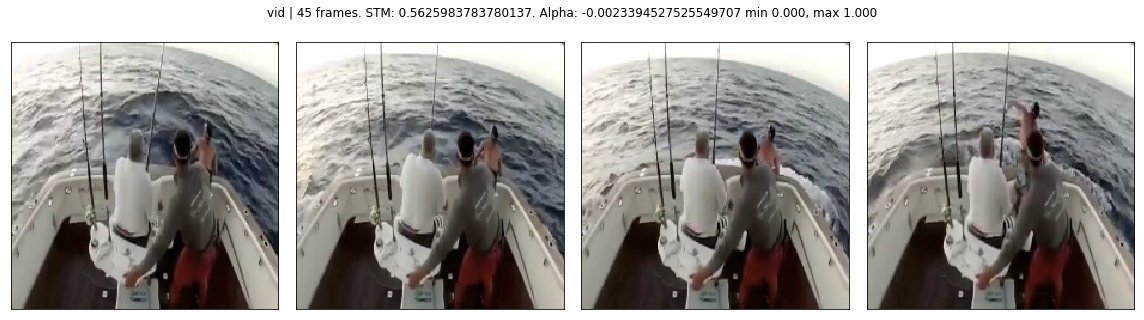

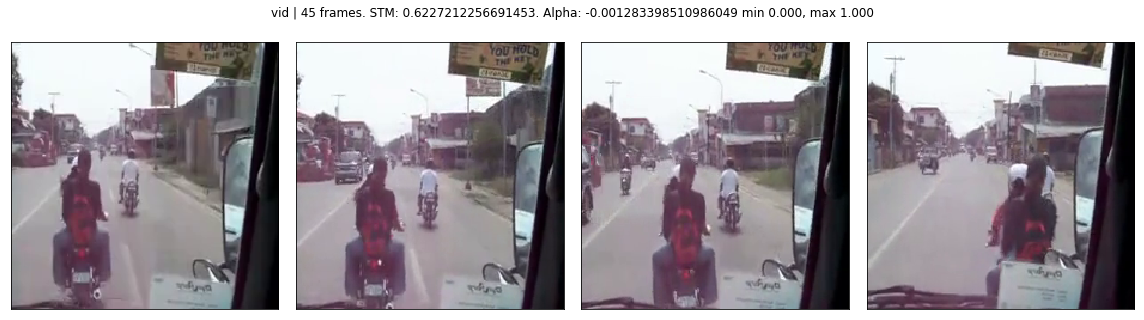

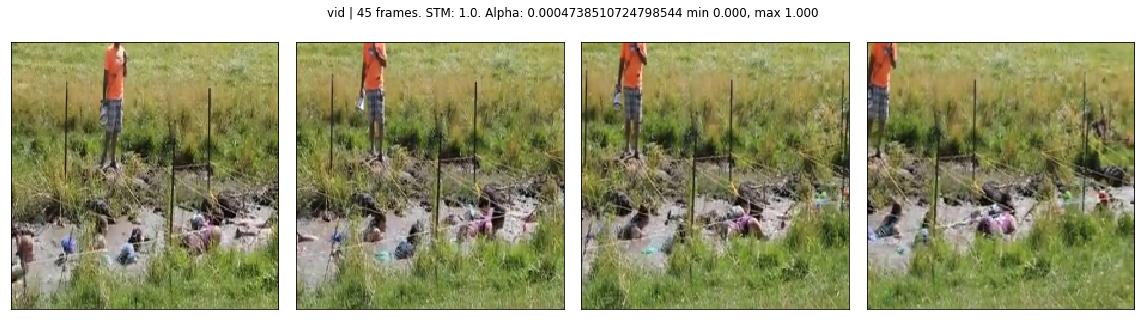

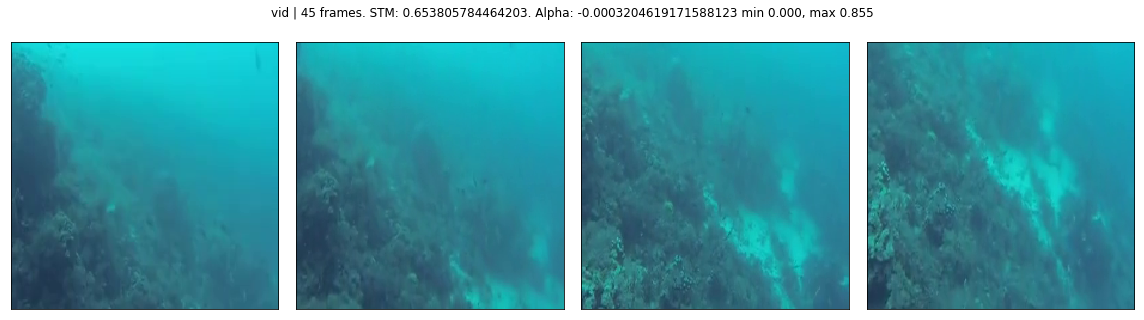

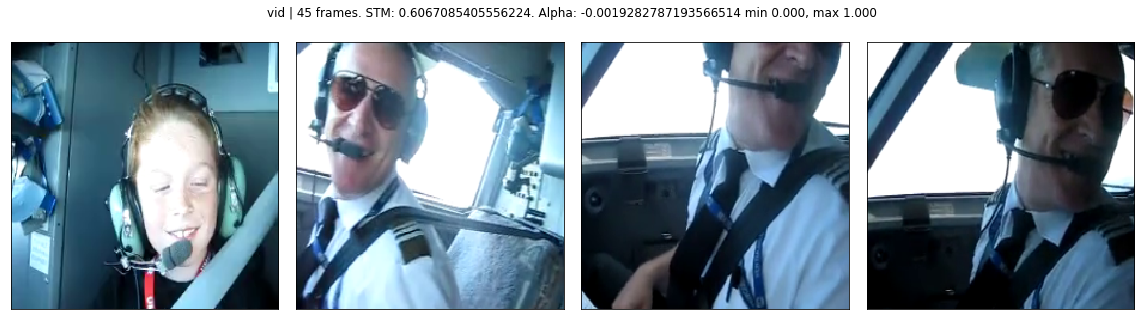

In [5]:

batch, labels = gen_test.__getitem__(0)

# Display
for i,b in enumerate(batch):
    mem, alpha = labels[i]
    plot_frames(b, 
                title='%s | %d frames. STM: %s. Alpha: %s' % ('vid',len(b),mem,alpha),
                is_optical_flow=True if TRAIN_ON=='flow' else False,
                suptitle_y=0.89,
                is_255image=True, 
                frames_to_show=4)

# Model

In [6]:
%%bash
cd ../ckpt/i3d
ls

memento10k_flow_ep02_valloss8.4081.hdf5
memento10k_flow_ep03_valloss8.4215.hdf5
memento10k_flow_fzn0_resc1_LTalphamse_a0b1c0_w1_gpus1_bs8_do0.50_ep18_valloss0.0318_valrc0.3915.hdf5
memento10k_flow_fzn0_resc1_LTalphamse_a0b1c0_w1_gpus1_bs8_do0.50_ep24_valloss0.0318_valrc0.3913.hdf5
memento10k_flow_fzn0_resc1_LTalphamse_a1b100c10_w1_gpus1_bs8_do0.50_ep01_valloss7.1522_valrc0.4311.hdf5
memento10k_flow_fzn0_resc1_LTalphamse_a1b100c10_w1_gpus1_bs8_do0.50_ep02_valloss6.5733_valrc0.4976.hdf5
memento10k_flow_fzn0_resc1_LTalphamse_a1b100c10_w1_gpus1_bs8_do0.50_ep03_valloss7.2907_valrc0.5196.hdf5
memento10k_flow_fzn0_resc1_LTalphamse_a1b100c10_w1_gpus1_bs8_do0.50_ep04_valloss6.1626_valrc0.5369.hdf5
memento10k_flow_fzn0_resc1_LTalphamse_a1b100c10_w1_gpus1_bs8_do0.50_ep05_valloss6.1988_valrc0.5322.hdf5
memento10k_flow_fzn0_resc1_LTalphamse_a1b100c10_w1_gpus1_bs8_do0.50_ep06_valloss7.6145_valrc0.5346.hdf5
memento10k_flow_fzn0_resc1_LTalphamse_a1b100c10_w1_gpus1_bs8_do0.50_ep07_valloss6.5017_valrc0.

In [7]:
# Fetching pretrained i3d
gpus=1
rescale=True

i3d = build_model_multigpu(ckpt=cfg._INIT_CKPT, 
                           type=TRAIN_ON, 
                           image_size=cfg._IMAGE_SIZE,
                           num_frames=cfg._NUM_FRAMES, 
                           num_classes=2,
                           gpus=gpus,
                           use_pretrained=True, 
                           verbose=True, 
                           download_weights=True,
                           downsample_factor=None, 
                           dropout_prob=0.5, 
                           final_activation='tanh', 
                           show_internal_summary=False,
                           rescale=rescale)


Working with single GPU
Instructions for updating:
Colocations handled automatically by placer.
x.shape after downsa: (?, 23, 28, 28, 192)
channels_last
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
x.shape after last conv: (?, 5, 1, 1, 400)
Loading downloaded weights into model: rgb_imagenet_and_kinetics from path: /afs/csail.mit.edu/u/v/vcasser/.keras/models/i3d_inception_rgb_imagenet_and_kinetics.h5
x.shape before last conv (?, 5, 1, 1, 1024)
x.shape after last conv (?, 5, 1, 1, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 45, 224, 224, 3)   0         
_________________________________________________________________
lambda_2 (Lambda)            (None, 45, 224, 224, 3)   0         
_________________________________________________________________
i3d_inception (Model)        multiple        

# Predict and eval RC

In [8]:
## DEFINE CHECKPOINTS TO USE

str_needed = 'flow_fzn0'

ckpts = [f for f in os.listdir('../ckpt/i3d') if str_needed in f and f.endswith('.hdf5')] [::-1]

ckpts = ['memento10k_rgb_fzn0_resc1_LTalphamse_w0_gpus1_bs8_ep10_valloss10.4754_valrc0.5194.hdf5',
         'memento10k_rgb_fzn0_resc1_LTalphamse_w0_gpus1_bs8_ep13_valloss10.5436_valrc0.5117.hdf5',
         'memento10k_rgb_fzn0_resc1_LTalphamse_w0_gpus1_bs8_ep09_valloss10.7079_valrc0.5136.hdf5'
        ]

ckpts = ['memento10k_rgb_fzn0_resc1_LTalphamse_a1b100c10_w1_gpus1_bs8_do0.30_ep01_valloss10.3820_valrc0.5919.hdf5']


print('%d CKPTS TO TRY:' % len(ckpts), ckpts)

1 CKPTS TO TRY: ['memento10k_rgb_fzn0_resc1_LTalphamse_a1b100c10_w1_gpus1_bs8_do0.30_ep01_valloss10.3820_valrc0.5919.hdf5']


In [9]:
from matplotlib import cm


def load_mem_scores(names, T, labels_path=labels_path):
    mem_scores_file = 'normalized_mem_scores_ma_T=%d.json' % T
    alpha_file = 'alphas_ma_T=%d.json' % T

    with open(os.path.join(labels_path, mem_scores_file)) as f:
        name_to_mem = json.load(f)

    with open(os.path.join(labels_path, alpha_file)) as f:
        name_to_alpha = json.load(f)

    true_mem=[]
    true_alpha=[]

    
    for n in names:
        cl = n.split('_')[0]
        cl = cl.replace('-','+')
        newn = cl+'/'+'_'.join(n.split('_')[1:]).replace('.npy','.mp4')
        true_mem.append(name_to_mem[newn])
        true_alpha.append(name_to_alpha[newn])
        
        
    return true_mem, true_alpha


def get_rank_corrs(pred, pred_alpha, names, T_to_try = [20,40,60,80,100,120,140,160,180], 
                   labels_path=labels_path, plot=True, followcurve=False):
    
    rc={}
    rc_alphas={}
    
    pred = np.array(pred)
    pred_alpha = np.array(pred_alpha)
    
    for T in T_to_try:
        
        true_mem, true_alpha = load_mem_scores(names, T, labels_path=labels_path)
                
#         print('len(pred), len(true_mem), len(pred_alpha), len(true_alpha)',
#               len(pred), len(true_mem), len(pred_alpha), len(true_alpha))
        
        if followcurve:
            pred = pred_alpha*(T-180)+pred
        
        rc[T] = spearmanr(pred, true_mem)[0]
        rc_alphas[T] = spearmanr(pred_alpha, true_alpha)[0]
        
        
#     print(pred[:10], true_mem[:10])
    if plot:
        plt.figure(figsize=[14,6])
        plt.subplot(1,2,1)
        plt.plot(rc.keys(), rc.values(), marker='o')
        plt.xlabel('Normalization lag (in videos)')
        plt.ylabel('Spearman rank correlation')
        plt.title('Rank correlation of preds with GT normalized at different T')
        plt.subplot(1,2,2)
        plt.plot(rc_alphas.keys(), rc_alphas.values(), marker='o', color='g')
        plt.xlabel('Normalization lag (in videos)')
        plt.ylabel('Spearman rank correlation')
        plt.title('Rank correlation of ALPHA preds with GT normalized at different T')
    
    return rc, rc_alphas


def plot_distribs(pred_mem, pred_alphas, names,  T_to_try = [20,40,60,80,100,120,140,160,180] , followcurve=False):
    
    pred_mem = np.array(pred_mem)
    pred_alphas = np.array(pred_alphas)
    plt.figure(figsize=[14,6])
    plt.subplot(1,2,1)
    if not followcurve: sns.distplot(pred_mem, color='cornflowerblue')
    legend = ['Predicted']
    true_alphas=[]
    
    cmap1 = cm.get_cmap('Spectral')
    cmap2 = cm.get_cmap('Blues')
    
    print(cmap1(1/len(T_to_try)))
    
    for i,T in enumerate(T_to_try):
        true_mem, ta = load_mem_scores(names, T)
        true_alphas.append(ta)
        sns.distplot(true_mem, color=cmap1(i/len(T_to_try)))
        legend.append('True, T=%d'%T)
        
        if followcurve:
#             print('T-180',T-180)
#             print('pred_alphas[:10]*(T-180)',pred_alphas[:10]*(T-180))
            pred_mem_n = pred_alphas*(T-180)+pred_mem
#             print(pred_mem[:10])
#             print(pred_mem_n[:10])
            
            c = cmap2(i/len(T_to_try))
    
            sns.distplot(pred_mem_n, color=(c[0],c[1],c[2],c[3]*0.9))
            legend.append('GT, T=%d'%T)
    
    plt.legend(legend)
                     
                      
    plt.subplot(1,2,2)
    sns.distplot(pred_alphas, label='Pred, T=%d'%T, color='cornflowerblue')
    
    for i,ta in enumerate(true_alphas):
        sns.distplot(ta, label='GT, T=%d'%T, color=cmap1(i/len(true_alphas)))
    plt.title('Distribution of alphas')
 
    plt.legend()


def plot_decay_curves(pred_mem, pred_alphas, names):
    pass
    
def plot_curve(alpha, mem):
    x = np.linspace(0, 200, 100)
    pts = alpha*(x-180) + mem
    plt.plot(x, pts)

In [10]:
def toggle_freeze(m, multigpu=True):
    
    if multigpu:
        if m.layers[-2].layers[2].layers[0].trainable:
            print('Freezing all but last 4 layers')
            for l in m.layers[-2].layers[2].layers:
                l.trainable=False
        else:
            print('Unfreezing all layers')
            for l in m.layers[-2].layers[2].layers:
                l.trainable=True
    else:
        if m.layers[2].layers[0].trainable:
            print('Freezing all but last 4 layers')
            m.layers[2].trainable=False
            for l in m.layers[2].layers:
                l.trainable=False
        else:
            print('Unfreezing all layers')
            for l in m.layers:
                l.trainable=True
            m.layers[2].trainable=True
            for l in m.layers[2].layers:
                l.trainable=True

    return m

In [11]:
# # Evaluate

# def loss_alpha(y_true, y_pred):
#     base_true = y_true[:, 0]
#     alpha_true = y_true[:, 1]
#     base_pred = y_pred[:, 0]
#     alpha_pred = y_pred[:, 1]
    
#     x = K.repeat_elements(K.expand_dims(K.constant(np.linspace(0, 180, 100)), axis=0), rep=bs, axis=0)
#     base_true = K.repeat_elements(K.expand_dims(base_true, axis=1), rep=100, axis=1)
#     base_pred = K.repeat_elements(K.expand_dims(base_pred, axis=1), rep=100, axis=1)

#     alpha_true = K.repeat_elements(K.expand_dims(alpha_true, axis=1), rep=100, axis=1)
#     alpha_pred = K.repeat_elements(K.expand_dims(alpha_pred, axis=1), rep=100, axis=1)

#     y_true = alpha_true * (x - 180.) + base_true
#     y_pred = alpha_pred * (x - 180.) + base_pred
#     return K.mean(K.sum(K.abs(y_true - y_pred), axis=1))

# i3d.compile(optimizer=Adam(lr=0.0001, amsgrad=True),
#               loss=loss_alpha,
#               metrics=['mse'])

# metrics = i3d.evaluate_generator(gen_val, verbose=1, max_queue_size=20, workers=10)
# print(metrics)

In [14]:
# Predict
save=True
do_val=True
load_if_exists=True


pred_mem_val=[]
pred_mem_test=[]
pred_alpha_val=[]
pred_alpha_test=[]

for c in ckpts:
    
    savepath = '../preds/i3d/'
    savename = os.path.join(savepath, c.split('/')[-1].replace('.hdf5','.npy'))
    
    if os.path.isfile(savename) and load_if_exists: # if predictions exist for this ckpt
        
        print('Loading predictions for weights:', c)
        preds_val, preds_test = np.load(savename)
        
    else: # predict
    
        # Load weights
        print('Loading weights:', c)
        
        try:
            i3d.load_weights(os.path.join('../ckpt/i3d',c))    
        except Exception as err:
            i3d = toggle_freeze(i3d, multigpu=gpus>1)
            i3d.load_weights(os.path.join('../ckpt/i3d',c))    

        if do_val: 
            preds_val = i3d.predict_generator(gen_val, verbose=1, max_queue_size=20, workers=30)
        preds_test = i3d.predict_generator(gen_test, verbose=1, max_queue_size=20, workers=30)

    pred_mem_val.append([p[0] for p in preds_val])
    pred_alpha_val.append([p[1] for p in preds_val])
    
    pred_mem_test.append([p[0] for p in preds_test])
    pred_alpha_test.append([p[1] for p in preds_test])

    
    if save:
        if not os.path.exists(savepath):
            os.makedirs(savepath)
        if not os.path.isfile(savename):
            np.save(savename, [preds_val, preds_test])


Loading weights: memento10k_rgb_fzn0_resc1_LTalphamse_a1b100c10_w1_gpus1_bs8_do0.30_ep01_valloss10.3820_valrc0.5919.hdf5

Total time on this batch: 5.315676080994308  - it: 0 - idx: 12
Time loading: 4.116390256211162
Time preprocessing: 1.199277856387198
Time augmenting: 7.968395948410034e-06
188/188 [==============================] - 174s 926ms/step


# Visualize distributions and rank correlation

In [2]:
for i,c in enumerate(ckpts):
    print('CKPT:', c)
    if do_val:
        print('VALIDATION')
        rc_v, rc_alpha_v = get_rank_corrs(pred_mem_val[i], pred_alpha_val[i], val_names[:len(pred_mem_val[i])], followcurve=True)
        plot_distribs(pred_mem_val[i], pred_alpha_val[i], val_names[:len(pred_mem_val[i])], followcurve=True)
        plt.show()

    print('TEST')
    rc_t, rc_alpha_t = get_rank_corrs(pred_mem_test[i], pred_alpha_test[i], test_names[:len(pred_mem_test[i])], followcurve=False)
    plot_distribs(pred_mem_test[i], pred_alpha_test[i], test_names[:len(pred_mem_test[i])], followcurve=False)
    plt.show()
    
    
    print('CKPT %s SUMMARY:' % c)
    if do_val:
        print('VALIDATION RC:')
        for k,v in rc_v.items():
            print('T=%d: %.4f' % (k, v))
    print('TEST RC:')
    for k,v in rc_t.items():
        print('T=%d: %.4f' % (k, v))

NameError: name 'ckpts' is not defined

 # Plot distributions

In [ ]:
import seaborn as sns

plt.figure()
sns.distplot(pred_mem)
sns.distplot(true_mem)
plt.legend(['Predicted', 'True'])

In [ ]:
plt.figure()
sns.distplot(pred_alpha)
sns.distplot(true_alpha)
plt.legend(['Predicted', 'True'])

In [ ]:
for i,a in enumerate(true_alpha):
    plot_curve(true_alpha[i], true_mem[i])
    plot_curve(pred_alpha[i], pred_mem[i])
    break
    